# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv',
               '../../data/cleaned/utah_2017_bird.csv']

test_files = ['../../data/cleaned/utah_2018_vineyard.csv', 
               '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 1
test_index = 1

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2
1,5/5/2017,0:15,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2
2,5/5/2017,0:30,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2
3,5/5/2017,0:45,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3
4,5/5/2017,1:00,15.63,1821,-104.5,8.33,6.72,89.5,8.86,0.3


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,17851.000000,17851.000000,17851.000000,17851.000000,17282.000000,17851.000000,17851.000000,17851.000000
mean,19.084273,1865.934177,-119.627987,8.578680,64.962507,86.837617,8.051712,0.944709
std,5.620165,214.930180,8.060376,0.136279,52.098506,17.599854,1.539109,0.873847
min,8.580000,1.000000,-151.100000,7.890000,1.540000,37.200000,3.000000,-0.300000
25%,13.850000,1780.000000,-124.400000,8.460000,21.057500,79.000000,7.100000,0.500000
50%,21.110000,1909.000000,-119.200000,8.600000,58.655000,83.100000,8.160000,0.700000
75%,23.820000,2029.000000,-113.900000,8.670000,87.990000,90.400000,9.090000,1.100000
max,28.750000,2139.000000,-81.200000,9.080000,418.960000,221.400000,17.540000,13.700000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00
2017-05-05 01:00:00,15.63,1821,-104.5,8.33,6.72,89.5,8.86,0.3,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## BGA RFU Levels

In [10]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [11]:
def windowize(df, time_column):
    print("Segmenting...")
    x_windows, y_windows = hf.segment_dataset(df, time_column)
    print("Extracting feature windows...")
    x_windows = hf.extract_percentile(x_windows, time_column)
    print("Extracting target windows...")
    y_windows = hf.extract_percentile(y_windows, time_column)
    print("Combining extractions...")
    x_windows[target_column] = y_windows[target_column].values
    return x_windows

In [12]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = windowize(train_dfs[i], 'datetime')
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = windowize(test_dfs[i], 'datetime')
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



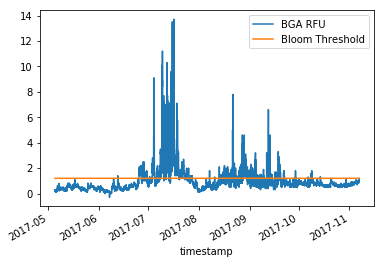

In [13]:
presegmented_plot.plot.line()

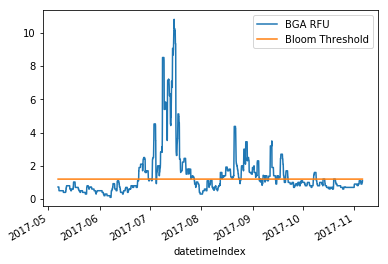

In [14]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

## Logistic Regression Model

In [15]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

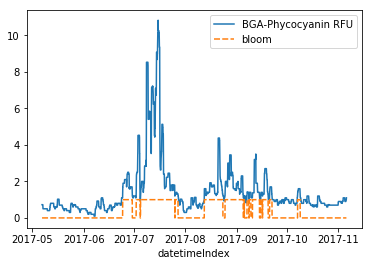

In [16]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

In [ ]:
# The null model's performance
accuracy, recall, precision, cm, _, _, _ = train_model(
            model, training_df, testing_df, [column], y_column)

In [17]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Temp C
Accuracy 0.608623203499271
Recall: 0.4152907394113424
Precision 0.822316986496091
Confusion Matrix:
 [[1765  250]
 [1629 1157]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: pH (mV)
Accuracy 0.5802957717142262
Recall: 1.0
Precision 0.5802957717142262
Confusion Matrix:
 [[   0 2015]
 [   0 2786]]

Training model with: pH
Accuracy 0.6765257238075401
Recall: 0.91816223977028
Precision 0.6587689930466134
Confusion Matrix:
 [[ 690 1325]
 [ 228 2558]]

Training model with: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: ODOSat%
Accuracy 0.7204749010622787
Recall: 0.6256281407035176
Precision 0.8535749265426053
Confusion Matrix:
 [[1716  299]
 [1043 1743]]

Training model with: ODO (mg/L)
Accuracy 0.7023536763174338
Recall: 0.592964824120603
Precision 0.8484848484848485
Confusion Matrix:
 [[1720  295]
 [1134 1652]]

ODOSat% metric value: 0.7204749010622787
ODO (mg/L) metric value: 0.7023536763174338
pH metric value: 0.6765257238075401
Temp C metric value: 0.608623203499271
pH (mV) metric value: 0.5802957717142262
Sp Cond (uS/cm) metric value: 0.4197042282857738
Turbidity (NTU) metric value: 0.4197042282857738


In [18]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training model with: ['ODOSat%']
Test model accuracy: 0.7204749010622787
Test model recall: 0.6256281407035176
Test model precision: 0.8535749265426053

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7008956467402624
Test model recall: 0.5825556353194544
Test model precision: 0.8560126582278481

Training model with: ['ODOSat%', 'pH']
Test model accuracy: 0.7317225578004583
Test model recall: 0.8894472361809045
Test model precision: 0.7165991902834008

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'Temp C']
Test model accuracy: 0.7106852739012706
Test model recall: 0.881191672648959
Test model precision: 0.6988329063478509

Training model with: ['ODOSat%', 'pH', 'pH (mV)']
Test model accuracy: 0.7519266819412622
Test model recall: 0.8104809763101221
Test model precision: 0.7730229373502225

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'pH (mV)', 'Sp Cond (uS/cm)']
Test model accuracy: 0.684232451572589
Test m

Model AUC: 0.8226


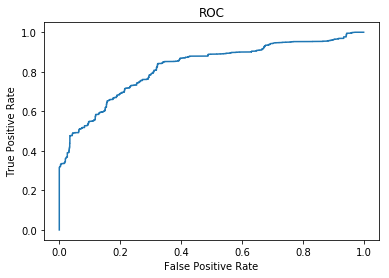

In [19]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

## Random Forest Model

In [20]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.6759008539887523
Recall: 0.9475951184493898
Precision 0.6518518518518519
Confusion Matrix:
 [[ 605 1410]
 [ 146 2640]]


In [21]:
# Greedy Model
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', sorted_columns)

Training model with: ['ODOSat%']


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.6913143095188502
Test model recall: 0.674802584350323
Test model precision: 0.7654723127035831

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.6961049781295563
Test model recall: 0.7605886575735822
Test model precision: 0.7279285468911028

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.6715267652572381
Test model recall: 0.9253409906676239
Test model precision: 0.6531542944008107

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0.7290147885857113
Test model recall: 0.739770279971285
Test model precision: 0.7815699658703071

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C', 'pH (mV)']
Test model accuracy: 0.5525932097479692
Test model recall: 0.9267767408470926
Test model precision: 0.5704816615112682

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.812330764

Model AUC: 0.8727


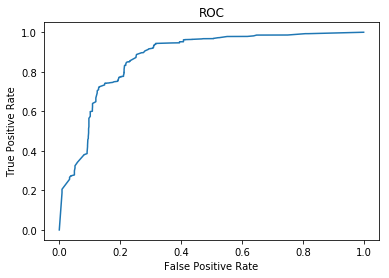

In [22]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)